# Image encoding benchmark

Visualize pretrainer results on a given image and measure the encoding time.

First, build the model:

In [25]:
import sys
sys.path.append("../")
from multitudinous.utils.model_builder import build_img_backbone
import torch

BACKBONE_VARIANT = "resnet50"

# build the model
model = build_img_backbone(BACKBONE_VARIANT, "../output_ae/img_backbone_15.pth")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

model.eval()

# print the model
print(model)

ResNet(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Now, create the dataset and dataloader instances:

In [26]:
from multitudinous.utils.dataset_builder import build_img_dataset

# build the dataset
dataset = build_img_dataset("tum_rgbd", "../../data/tum_rgbd1")

Now, run inference on a given image:

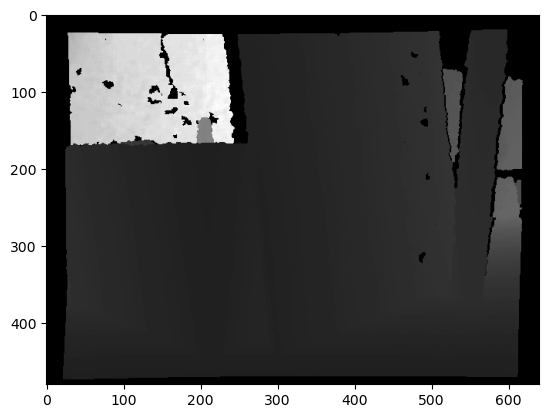

** resnet50 METRICS **
Encoding time: 39.24272155761719 ms
Throughput: 25.482432418245352 fps


In [27]:
import matplotlib.pyplot as plt
import torch

# create the timers
starter = torch.cuda.Event(enable_timing=True)
ender = torch.cuda.Event(enable_timing=True)

SAMPLE_NUM=20

# pick the "SAMPLE_NUM" sample from the dataset
rgb, depth = dataset[SAMPLE_NUM]

# plot the depth image
plt.imshow(depth, cmap='gray')
plt.show()

# move the images to the device
rgb = rgb.to(device)
depth = depth.to(device)
depth = depth.unsqueeze(0)
rgbd = torch.cat((rgb, depth), dim=0)

# run inference
with torch.no_grad():
    starter.record() # start recording
    output = model(rgbd.unsqueeze(0))
    ender.record()
    torch.cuda.synchronize()
    elapsed_time = starter.elapsed_time(ender)

print(f"** {BACKBONE_VARIANT} METRICS **")
print(f"Encoding time: {elapsed_time} ms")
print(f"Throughput: {1/(elapsed_time/1000)} fps")

del model, rgb, depth, rgbd, output